In order to understand and define bussiness questions for our dataset, we should explore some of its characteristics. First we need to load our csv files. This dataset contain 2 csv files for Movie Title and Actor/Director data from these movies. For further exploration we can use both these files to make a recommendation system base on the link between Movies and Actors but for now, let's just analyze the Move Title only.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./titles.csv')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


In [6]:
rows = df.shape[0]
columns = df.shape[1]
print(rows, columns)

5806 15


We have total 5806 rows and 15 columns of attributes. But not all our columns can be used to define questions, some unique columns such as id, title, description, imdb_id can only give us infor about that title but not the whole picture. For now let's just ignore them first.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

We have some columns with object type (string, list). For categorial columns like **type** with String, personal I would like to transform them to some primitive type other than String but just leave them alone and comeback when we need them. Another categorial columns we should take care of is **genres** when it's datatype Array and may need us to clean around.

In [75]:
list(set(df.columns[df.isna().mean() > 0.25]))

['age_certification', 'seasons']

Theoretically, 25 to 30% of missing value can be allowed, above this threshold we should consider the impact of these columns to our bussiness. In this case **season** can only applied on titles with **type** is SHOW. For **age_certification** is allowed in this case because not all producers tag their movies with this, we can assume these moves can be watched by everyone.

# Question 1
*Which genres have the most movies?*

Here we have mulitple value is combined to an array, in order to count by each value, we must extract these values and count them seperate on total. First we need extract all value from our DataFrame.

In [56]:
genres_values = df['genres'].value_counts()
list_genres_values = []
for val in genres_values.index.values.tolist():
    # Due to string in numpy, we have to split value by ',' also remove empty space on our object
    tmp = [t.replace('\'', '').strip() for t in val[1:-1].split(',')]
    list_genres_values += tmp
# Convert to set to remove duplicate and empty string
list_genres_values = list(filter(None, list(set(list_genres_values))))

['animation',
 'drama',
 'horror',
 'documentation',
 'war',
 'european',
 'thriller',
 'comedy',
 'family',
 'reality',
 'fantasy',
 'crime',
 'action',
 'romance',
 'sport',
 'scifi',
 'western',
 'history',
 'music']

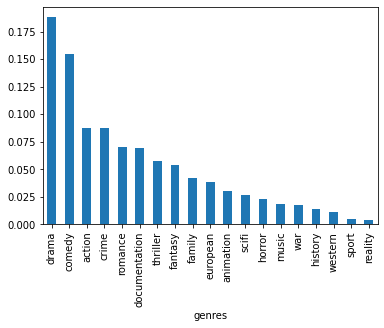

In [76]:
from collections import defaultdict
genres_df = defaultdict(int)
genres_values = df['genres'].value_counts().reset_index()
genres_values.rename(columns={'index': 'genres', 'genres': 'count'}, inplace=True)
for val in list_genres_values:
    for idx in range(genres_values.shape[0]):
        if val in df['genres'][idx]:
            genres_df[val] += int(genres_values['count'][idx])
genres_df = pd.DataFrame(pd.Series(genres_df)).reset_index()
genres_df.columns = ['genres', 'count']
genres_df.sort_values('count', ascending=False, inplace=True)
genres_df.set_index('genres', inplace=True)
(genres_df/genres_df.sum()).plot(kind='bar', legend=None);

# Question 2
*What is the best age-certification tag for drama movies?*

First we need to filter all movies with drama genres in it.

In [79]:
genres_df = df[df['genres'].str.contains('drama')]
genres_df['age_certification'].value_counts()

TV-MA    524
R        325
TV-14    288
PG-13    251
PG       119
TV-PG     61
G         44
TV-Y7     30
TV-G      19
NC-17     10
TV-Y       7
Name: age_certification, dtype: int64

# Question 3
*How many movies has drama factor released every year? And Does their quality increase overtime?*

<AxesSubplot:xlabel='release_year'>

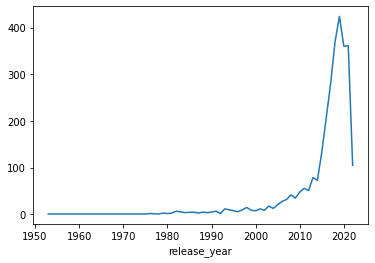

In [117]:
genres_df.groupby(by='release_year')['id'].count().plot(kind='line')

For IMDB Score, we can fill the NaN with 0.0 and in a group with 0.0 score collected.

In [125]:
genres_df = df[df['genres'].str.contains('drama')]
genres_df['imdb_score'].isnull().values.any()
genres_df['imdb_score'].isnull().sum()

128

In [128]:
genres_df[genres_df['imdb_score'].isnull()]['release_year'].value_counts()

2020    47
2019    23
2021    15
2018    10
2022     6
2016     5
2017     4
2013     3
2008     2
2015     2
2014     1
1981     1
1991     1
2011     1
2010     1
2009     1
2002     1
2006     1
2001     1
1999     1
2012     1
Name: release_year, dtype: int64

In [130]:
new_df = genres_df[genres_df['imdb_score'].notna()]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2773 entries, 1 to 5803
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2773 non-null   object 
 1   title                 2773 non-null   object 
 2   type                  2773 non-null   object 
 3   description           2772 non-null   object 
 4   release_year          2773 non-null   int64  
 5   age_certification     1625 non-null   object 
 6   runtime               2773 non-null   int64  
 7   genres                2773 non-null   object 
 8   production_countries  2773 non-null   object 
 9   seasons               981 non-null    float64
 10  imdb_id               2773 non-null   object 
 11  imdb_score            2773 non-null   float64
 12  imdb_votes            2771 non-null   float64
 13  tmdb_popularity       2739 non-null   float64
 14  tmdb_score            2670 non-null   float64
dtypes: float64(5), int64(

Let's check IMDB Score over years on drama genres to see if the quality of these move does improved or not.

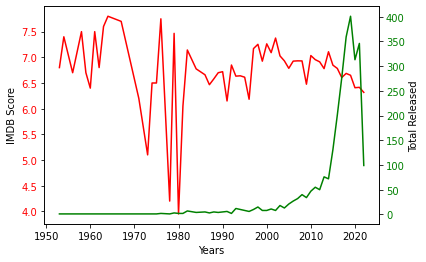

In [148]:
fig, ax1 = plt.subplots()
ax1.plot(new_df.groupby(by='release_year')['imdb_score'].mean(), color='red', label='imdb_score')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel('IMDB Score')
ax1.set_xlabel('Years')
ax2 = ax1.twinx()
ax2.plot(new_df.groupby(by='release_year')['id'].count(), color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('Total Released')
plt.show()